In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, BatchNormalization
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import pytz as timezone

2024-01-05 09:33:33.906212: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 09:33:34.861045: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 09:33:34.863503: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 09:33:37.517582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 1. Data Preprocessing
df = pd.read_csv('real_train_with_time.csv')


In [3]:
# Convert timestamp to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
#df.sort_values(by="timestamp")["timestamp"].head(50)

In [5]:
### get random sample and try different losses - see which loss is the best in data analysis stage


### TEMP for testing - comment when finished
###df = df.head(100)
# Randomly select subset_size rows from the training dataset
df = df.sample(n=1000, random_state=42)
####

# Create an empty DataFrame with the specified columns
gan_synth_data = pd.DataFrame(columns=df.columns)
# Save the empty DataFrame to a CSV file
gan_synth_data.to_csv('gan_synthetic_data_with_time.csv', index=False)

# Convert timestamp to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Ensure that timestamps are timezone-aware
df['timestamp'] = df['timestamp'].dt.tz_convert('UTC')
# Extract hour, day of week, and month from timestamp
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_of_month'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month



In [6]:
scaler = MinMaxScaler()
# fit transform on all column names except the first one which is the timestamp
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

# num of feature for the model architechcture
num_features = df.shape[1] - 1

# excluding the header
num_rows = df.shape[0]

In [7]:
df.head(2)

,timestamp,pmPftEstablishedSession,pmRrcConnSuspend,pmUeCtxtRelAbnormalEnbLic,pmDlAssigsTransPCell,pmActiveUeDlSectorCarrierDistr_0,pmActiveUeDlSectorCarrierDistr_1,pmActiveUeDlSectorCarrierDistr_2,pmActiveUeDlSectorCarrierDistr_3,pmActiveUeDlSectorCarrierDistr_4,...,pmDynUeAdmCtrlQueueSizeDistr_7,pmDynUeAdmCtrlQueueSizeDistr_8,pmDynUeAdmCtrlQueueSizeDistr_9,pmHoPrepRejInMISigQCong,pmErabLevSum,pmUeCtxtFetchSuccUeCapEnq,hour,day_of_week,day_of_month,month
3365,2023-09-16 23:45:00+00:00,0.0,0.0,0.0,0.052326,0.037929,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.077026,0.0,1.000000,0.833333,0.727273,0.0
1945,2023-09-11 05:00:00+00:00,0.0,0.0,0.0,0.024677,0.026835,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.033331,0.0,0.217391,0.000000,0.272727,0.0


In [8]:
df.sort_values(by='timestamp')

,timestamp,pmPftEstablishedSession,pmRrcConnSuspend,pmUeCtxtRelAbnormalEnbLic,pmDlAssigsTransPCell,pmActiveUeDlSectorCarrierDistr_0,pmActiveUeDlSectorCarrierDistr_1,pmActiveUeDlSectorCarrierDistr_2,pmActiveUeDlSectorCarrierDistr_3,pmActiveUeDlSectorCarrierDistr_4,...,pmDynUeAdmCtrlQueueSizeDistr_7,pmDynUeAdmCtrlQueueSizeDistr_8,pmDynUeAdmCtrlQueueSizeDistr_9,pmHoPrepRejInMISigQCong,pmErabLevSum,pmUeCtxtFetchSuccUeCapEnq,hour,day_of_week,day_of_month,month
8,2023-09-08 17:45:00+00:00,0.0,0.0,0.0,0.022147,0.083660,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.044461,0.0,0.739130,0.666667,0.0,0.0
12,2023-09-08 17:45:00+00:00,0.0,0.0,0.0,0.315090,0.221772,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.745188,0.0,0.739130,0.666667,0.0,0.0
26,2023-09-08 18:30:00+00:00,0.0,0.0,0.0,0.024142,0.073445,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.061325,0.0,0.782609,0.666667,0.0,0.0
29,2023-09-08 18:30:00+00:00,0.0,0.0,0.0,0.479364,0.290698,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.577877,0.0,0.782609,0.666667,0.0,0.0
17,2023-09-08 18:30:00+00:00,0.0,0.0,0.0,0.331272,0.213671,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.322668,0.0,0.782609,0.666667,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,2023-09-19 14:15:00+00:00,0.0,0.0,0.0,0.521907,0.251142,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.343933,0.0,0.608696,0.166667,1.0,0.0
5304,2023-09-19 14:15:00+00:00,0.0,0.0,0.0,0.041634,0.081456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.071376,0.0,0.608696,0.166667,1.0,0.0
5312,2023-09-19 14:30:00+00:00,0.0,0.0,0.0,0.488807,0.249531,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.349980,0.0,0.608696,0.166667,1.0,0.0
5323,2023-09-19 14:30:00+00:00,0.0,0.0,0.0,0.304975,0.192323,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.511073,0.0,0.608696,0.166667,1.0,0.0


In [9]:
df.shape[0] 

1000

In [10]:
df.shape[1]

6496

In [11]:
num_features, num_rows

(6495, 1000)

In [12]:
# 1. GAN Model - Architechture
def build_generator(latent_dim):
    generator = Sequential()
    generator.add(Dense(num_rows, input_dim=latent_dim, activation='relu'))
    generator.add(BatchNormalization())
    generator.add(Dense(512, activation='relu'))
    generator.add(BatchNormalization())
    generator.add(Dense(64, activation='relu'))
    generator.add(BatchNormalization())
    generator.add(Dense(32, activation='relu'))
    generator.add(BatchNormalization())
    generator.add(Dense(num_features, activation='sigmoid'))
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    return generator


def build_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(num_rows, input_dim=num_features, activation='relu'))
    discriminator.add(BatchNormalization())
    discriminator.add(Dense(512, activation='relu'))
    discriminator.add(BatchNormalization())
    discriminator.add(Dense(64, activation='relu'))
    discriminator.add(BatchNormalization())
    discriminator.add(Dense(32, activation='relu'))
    discriminator.add(BatchNormalization())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    return discriminator


def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(gan_input, gan_output)
    # gan.compile(loss='binary_crossentropy', optimizer='adam')
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00002, beta_1=0.3))
    return gan


def train_gan(generator, discriminator, gan, X_train, epochs=4000, batch_size=32):
    d_losses_fake = []
    d_losses_real = []
    g_losses = []

    for epoch in range(epochs):
        # Generate random noise as input to the generator
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))

        # Generate synthetic data with the generator
        synthetic_data = generator.predict(noise)

        # Select a random batch of real data
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]

        # Labels for the generated and real data
        fake_labels = np.zeros((batch_size, 1))
        real_labels = np.ones((batch_size, 1))

        # Train the discriminator
        d_loss_fake = discriminator.train_on_batch(synthetic_data, fake_labels)
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

        # Train the generator
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Append losses for plotting
        d_losses_fake.append(d_loss_fake)
        d_losses_real.append(d_loss_real)
        g_losses.append(g_loss)

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")

    # Plotting training losses
    '''
    Ideal Behavior in Training Loss Plots:  
    Discriminator Loss (Fake and Real):  
    Fake Loss: Initially, the fake loss might be high as the generator is not yet producing realistic data. 
    It should decrease over time as the generator improves.
    Real Loss: The real loss should decrease steadily as the discriminator becomes adept at distinguishing 
    real data from fake data.
    Generator Loss:  
    The generator loss should increase over epochs, indicating that the generator is producing more 
    realistic data that challenges the discriminator.
    Indications and Adjustments:  
    Overfitting: 
    Discriminator Loss (Real): If the discriminator loss on real data decreases too quickly and stabilizes
    at a very low value, it might indicate overfitting. To address this, you can try adjusting the 
    capacity of your discriminator or introducing regularization techniques.
    Generator Loss: If the generator loss plateaus or stops increasing, it may suggest overfitting or 
    mode collapse. Adjustments such as modifying the architecture, tweaking learning rates, or 
    exploring different loss functions may help.
    Mode Collapse:
    If the generator consistently produces similar samples regardless of the input noise, it's a sign of 
    mode collapse. You can address this by adjusting the architecture, experimenting with different 
    optimization strategies, or implementing advanced GAN techniques.
    Discriminator Saturation:
    If the discriminator loss saturates and stops decreasing, it might indicate that the discriminator is 
    too powerful. Adjusting the capacity of the discriminator or modifying the learning rates can be helpful.
    Fluctuations in Loss: 
    Some fluctuations in losses are normal, but if they are too erratic or do not stabilize over time, it
    might indicate instability in training. Adjusting the learning rates, introducing batch normalization, 
    or experimenting with different GAN variants could help.
        
    Discriminator Loss:
    The discriminator loss should decrease over epochs. This indicates that the discriminator is getting 
    better at distinguishing between real and generated data. A decreasing discriminator loss suggests that
    the generator is producing data that is becoming more difficult for the discriminator to differentiate
    from real data.
    Generator Loss:   
    The generator loss should increase over epochs. This means that the generator is learning to produce 
    data that is more realistic and harder for the discriminator to distinguish. An increasing generator 
    loss is a positive sign that the generator is improving its ability to generate data that resembles 
    the real data distribution.
    It's worth noting that the loss curves might not always follow a smooth trajectory, and some 
    fluctuation is normal during GAN training. The key is to observe the overall trend over epochs. If 
    both the discriminator and generator losses are stabilizing or converging, it suggests that the GAN is 
    learning effectively. If there are issues, such as the generator loss not increasing, it may indicate 
    challenges in the training process that need to be addressed.
    '''
    # Plotting training losses
    plt.figure(figsize=(12, 6))
    plt.plot(range(epochs), d_losses_fake, label='Discriminator Loss (Fake Down)')
    plt.plot(range(epochs), d_losses_real, label='Discriminator Loss (Real Down)')
    plt.plot(range(epochs), g_losses, label='Generator Loss Up')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Losses Over Epochs')
    plt.legend()
    plt.show()


In [13]:
# Set the random seed for reproducibility
np.random.seed(100)

# Set latent dimension and build models
latent_dim = len(df.columns) - 4
generator_model = build_generator(latent_dim)
discriminator_model = build_discriminator()
gan_model = build_gan(generator_model, discriminator_model)

# Convert DataFrame to numpy array
X_train = df.iloc[:, 1:].to_numpy()


1/1 [==============================] - 0s 322ms/step
Epoch 0, D Loss: 0.8651016056537628, G Loss: 1.0712623596191406
1/1 [==============================] - 0s 41ms/step
Epoch 100, D Loss: 0.6975773870944977, G Loss: 0.13861387968063354
1/1 [==============================] - 0s 34ms/step
Epoch 200, D Loss: 0.6951934695243835, G Loss: 0.30308204889297485
1/1 [==============================] - 0s 37ms/step
Epoch 300, D Loss: 0.6943461894989014, G Loss: 0.350500226020813
1/1 [==============================] - 0s 38ms/step
Epoch 400, D Loss: 0.6938385367393494, G Loss: 0.3824264407157898
1/1 [==============================] - 0s 39ms/step
Epoch 500, D Loss: 0.6935655772686005, G Loss: 0.36752811074256897
1/1 [==============================] - 0s 62ms/step
Epoch 600, D Loss: 0.6935774981975555, G Loss: 0.09830284118652344
1/1 [==============================] - 0s 39ms/step
Epoch 700, D Loss: 0.693506270647049, G Loss: 0.2573746144771576
1/1 [==============================] - 0s 35ms/step
Epo

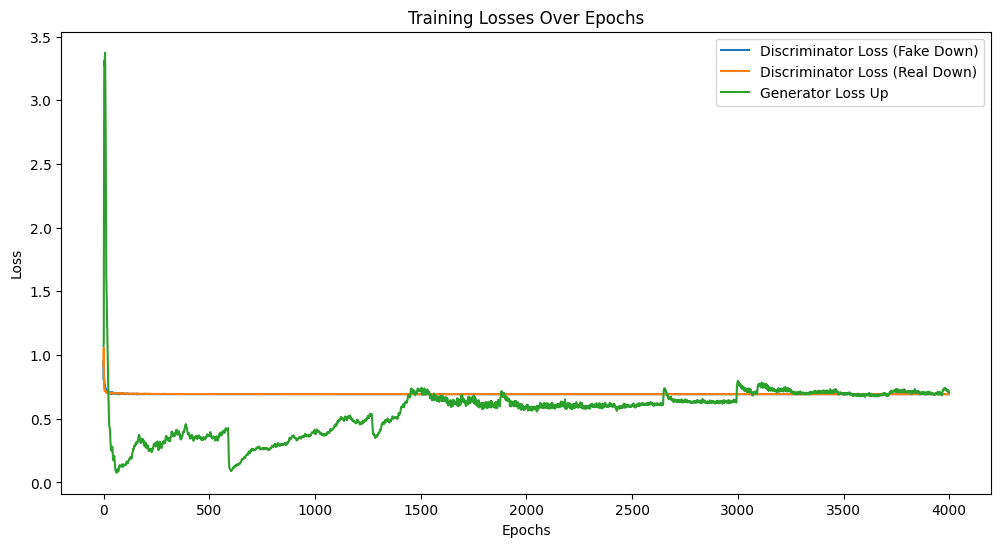

In [14]:
# Train the GAN
train_gan(generator_model, discriminator_model, gan_model, X_train)

In [15]:
model_name = "gan_model.h5"
# Save the GAN model
gan_model.save(model_name)

if os.path.exists(model_name):
    # To load the saved model later
    loaded_gan = load_model(model_name)

/opt/conda/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# 4. Data Generation
def generate_synthetic_data(generator, timestamp):
    # Convert the timestamp to the required format
    input_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)

    # Extract hour, day of week, and month from timestamp
    hour = input_timestamp.hour
    day_of_week = input_timestamp.weekday()
    day_of_month = input_timestamp.day
    month = input_timestamp.month
    # Normalize the extracted features to the range [0, 1]
    normalized_hour = hour / 23
    normalized_day_of_week = day_of_week / 6
    normalized_day_of_month = day_of_month / 29  # change this on the actual n of day in that month -1
    normalized_month = month / 11

    # Generate synthetic data for the given features
    noise = np.random.normal(0, 1, size=(latent_dim - 5,))  # Subtract 5 for hour, day_of_week, month, day_of_month
    features = np.array([[normalized_hour, normalized_day_of_week, normalized_day_of_month, normalized_month]])
    # Concatenate the normalized features to the noise as conditioning input
    noise_with_condition = np.concatenate([noise, features.reshape(-1)], axis=0)
    noise_with_condition = np.reshape(noise_with_condition, (1, -1))
    noise_with_condition = np.pad(noise_with_condition, ((0, 0), (0, 1)), 'constant')
    synthetic_data = generator.predict(noise_with_condition.reshape(1, -1))

    # Inverse transform to get the synthetic data in the original scale
    synthetic_data = scaler.inverse_transform(synthetic_data)
    print('h w d m')
    print(hour, day_of_week, day_of_month, month)
    print(np.round(synthetic_data.astype(int))[0][:-5])
    # rounding values and keepng as ints
    synthetic_data = np.round(synthetic_data.astype(int))
    # removing last 4 data points as they do not exist in real data
    synthetic_data = synthetic_data[:, :-4]

    # Create a DataFrame with the synthetic data but removing the first col timestamp and the last 4 cols with
    # feature engineered date and time integers as not retaining coluns for these here
    synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns[1:-4])

    # Set the timestamp column with the provided timestamp
    synthetic_df.insert(0, "timestamp", input_timestamp)
    #synthetic_df['timestamp'] = input_timestamp

    return synthetic_df


In [17]:
# # Example usage 2023-09-10T05:30:00+00:00
# # generate synthetic data for each hour from a specific start date - later change to 15 mins ROP instead of 1h
# initial_timestamp = '2023-09-08 01:00:00'
# timestamp = datetime.strptime(initial_timestamp, '%Y-%m-%d %H:%M:%S')
# hours_to_add = 24
# number_of_files_per_hour = 4
# for i in range(hours_to_add):
#     for _ in range(number_of_files_per_hour):
#         generated_data = generate_synthetic_data(generator_model, timestamp.strftime('%Y-%m-%d %H:%M:%S'))
#         generated_data.to_csv('gan_synthetic_data_with_time.csv', mode='a', index=False, header=False)
#     print(timestamp)
#     timestamp += timedelta(hours=1)

# ###generated_data = generate_synthetic_data(generator_model, '2023-09-08 19:00:00')

# '''
# # Read the CSV file
# df_original = pd.read_csv('gan_synthetic_data_with_time.csv')
# df_original['timestamp'] = pd.to_datetime(df_original['timestamp'])

# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calculate correlation matrix for the generated data
# correlation_matrix_generated = df_original.iloc[:, 0:10].corr()

# print(correlation_matrix_generated)

# # Create heatmap for the generated data
# plt.figure(figsize=(24, 10))

# # Heatmap for generated data
# plt.subplot(1, 2, 2)
# sns.heatmap(correlation_matrix_generated, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix for Generated Data')
# '''
# # Show the plot
# ###plt.show(

In [18]:
# Create an empty DataFrame with the specified columns
gan_synth_data_2 = pd.DataFrame(columns=df.columns)
# Save the empty DataFrame to a CSV file
gan_synth_data_2.to_csv('gan_real_synthetic_data_with_time.csv', index=False)

In [ ]:
initial_timestamp = '2023-09-08 17:45:00'
timestamp = datetime.strptime(initial_timestamp, '%Y-%m-%d %H:%M:%S')
hours_to_add = 24*82
number_of_files_per_hour = 4
for i in range(hours_to_add):
    for _ in range(number_of_files_per_hour):
        generated_data = generate_synthetic_data(generator_model, timestamp.strftime('%Y-%m-%d %H:%M:%S'))
        generated_data.to_csv('gan_real_synthetic_data_with_time.csv', mode='a', index=False, header=False)
    print(timestamp)
    timestamp += timedelta(minutes=15)

1/1 [==============================] - 0s 199ms/step
h w d m
17 4 8 9
[    0     0     0 ...     0     0 18754]
1/1 [==============================] - 0s 35ms/step
h w d m
17 4 8 9
[    0     0     0 ...     0     0 16192]
1/1 [==============================] - 0s 35ms/step
h w d m
17 4 8 9
[    0     0     0 ...     0     0 14368]
1/1 [==============================] - 0s 34ms/step
h w d m
17 4 8 9
[    0     0     0 ...     0     0 13479]
2023-09-08 17:45:00
1/1 [==============================] - 0s 44ms/step
h w d m
18 4 8 9
[    0     0     0 ...     0     0 18233]
1/1 [==============================] - 0s 30ms/step
h w d m
18 4 8 9
[    0     0     0 ...     0     0 19784]
1/1 [==============================] - 0s 34ms/step
h w d m
18 4 8 9
[    0     0     0 ...     0     0 16627]
1/1 [==============================] - 0s 36ms/step
h w d m
18 4 8 9
[    0     0     0 ...     0     0 17266]
2023-09-08 18:00:00
1/1 [==============================] - 0s 35ms/step
h w d m
18 4 8 9
[ 

In [39]:
new_predicted_values = pd.read_csv("gan_real_synthetic_data_with_time.csv")
new_predicted_values.head()

,timestamp,pmPftEstablishedSession,pmRrcConnSuspend,pmUeCtxtRelAbnormalEnbLic,pmDlAssigsTransPCell,pmActiveUeDlSectorCarrierDistr_0,pmActiveUeDlSectorCarrierDistr_1,pmActiveUeDlSectorCarrierDistr_2,pmActiveUeDlSectorCarrierDistr_3,pmActiveUeDlSectorCarrierDistr_4,...,pmDynUeAdmCtrlQueueSizeDistr_7,pmDynUeAdmCtrlQueueSizeDistr_8,pmDynUeAdmCtrlQueueSizeDistr_9,pmHoPrepRejInMISigQCong,pmErabLevSum,pmUeCtxtFetchSuccUeCapEnq,hour,day_of_week,day_of_month,month
0,2023-09-08 17:45:00+00:00,0,0,0,818719,2248441,0,0,0,0,...,0,0,0,0,18754,0,NaN,NaN,NaN,NaN
1,2023-09-08 17:45:00+00:00,0,0,0,752355,2965648,0,0,0,0,...,0,0,0,0,16192,0,NaN,NaN,NaN,NaN
2,2023-09-08 17:45:00+00:00,0,0,0,650586,3094722,0,0,0,0,...,0,0,0,0,14368,0,NaN,NaN,NaN,NaN
3,2023-09-08 17:45:00+00:00,0,0,0,646829,3306698,0,0,0,0,...,0,0,0,0,13479,0,NaN,NaN,NaN,NaN
4,2023-09-08 18:00:00+00:00,0,0,0,800160,2473353,0,0,0,0,...,0,0,0,0,18233,0,NaN,NaN,NaN,NaN


In [40]:
new_predicted_values['timestamp'] = pd.to_datetime(new_predicted_values['timestamp'])

In [41]:
df_temporary = pd.read_csv("real_train_with_time.csv")
df_temporary.head(2)

,timestamp,pmPftEstablishedSession,pmRrcConnSuspend,pmUeCtxtRelAbnormalEnbLic,pmDlAssigsTransPCell,pmActiveUeDlSectorCarrierDistr_0,pmActiveUeDlSectorCarrierDistr_1,pmActiveUeDlSectorCarrierDistr_2,pmActiveUeDlSectorCarrierDistr_3,pmActiveUeDlSectorCarrierDistr_4,...,pmDynUeAdmCtrlQueueSizeDistr_3,pmDynUeAdmCtrlQueueSizeDistr_4,pmDynUeAdmCtrlQueueSizeDistr_5,pmDynUeAdmCtrlQueueSizeDistr_6,pmDynUeAdmCtrlQueueSizeDistr_7,pmDynUeAdmCtrlQueueSizeDistr_8,pmDynUeAdmCtrlQueueSizeDistr_9,pmHoPrepRejInMISigQCong,pmErabLevSum,pmUeCtxtFetchSuccUeCapEnq
0,2023-09-08T17:45:00+00:00,0,0,0,659927,904307,0,0,0,0,...,0,0,0,0,0,0,0,0,18413,0
1,2023-09-08T17:45:00+00:00,0,0,0,647355,882597,0,0,0,0,...,0,0,0,0,0,0,0,0,16548,0


In [42]:
df_temporary = df_temporary.sort_values(by="timestamp").reset_index(drop=True)

In [43]:
df_temporary['timestamp'] = pd.to_datetime(df_temporary['timestamp'])

In [44]:
df_temporary.shape

(5340, 6492)

In [45]:
df_temporary.timestamp[:50]

0    2023-09-08 17:45:00+00:00
1    2023-09-08 17:45:00+00:00
2    2023-09-08 17:45:00+00:00
3    2023-09-08 17:45:00+00:00
4    2023-09-08 17:45:00+00:00
5    2023-09-08 17:45:00+00:00
6    2023-09-08 17:45:00+00:00
7    2023-09-08 17:45:00+00:00
8    2023-09-08 17:45:00+00:00
9    2023-09-08 17:45:00+00:00
10   2023-09-08 17:45:00+00:00
11   2023-09-08 17:45:00+00:00
12   2023-09-08 17:45:00+00:00
13   2023-09-08 17:45:00+00:00
14   2023-09-08 17:45:00+00:00
15   2023-09-08 18:30:00+00:00
16   2023-09-08 18:30:00+00:00
17   2023-09-08 18:30:00+00:00
18   2023-09-08 18:30:00+00:00
19   2023-09-08 18:30:00+00:00
20   2023-09-08 18:30:00+00:00
21   2023-09-08 18:30:00+00:00
22   2023-09-08 18:30:00+00:00
23   2023-09-08 18:30:00+00:00
24   2023-09-08 18:30:00+00:00
25   2023-09-08 18:30:00+00:00
26   2023-09-08 18:30:00+00:00
27   2023-09-08 18:30:00+00:00
28   2023-09-08 18:30:00+00:00
29   2023-09-08 18:30:00+00:00
30   2023-09-08 19:00:00+00:00
31   2023-09-08 19:00:00+00:00
32   202

In [46]:
unique_ts = df_temporary["timestamp"].unique()
unique_ts

<DatetimeArray>
['2023-09-08 17:45:00+00:00', '2023-09-08 18:30:00+00:00',
 '2023-09-08 19:00:00+00:00', '2023-09-08 20:00:00+00:00',
 '2023-09-08 20:15:00+00:00', '2023-09-08 21:00:00+00:00',
 '2023-09-08 21:15:00+00:00', '2023-09-08 22:00:00+00:00',
 '2023-09-08 22:15:00+00:00', '2023-09-08 22:30:00+00:00',
 ...
 '2023-09-19 11:00:00+00:00', '2023-09-19 11:15:00+00:00',
 '2023-09-19 12:00:00+00:00', '2023-09-19 12:15:00+00:00',
 '2023-09-19 12:30:00+00:00', '2023-09-19 12:45:00+00:00',
 '2023-09-19 13:00:00+00:00', '2023-09-19 14:00:00+00:00',
 '2023-09-19 14:15:00+00:00', '2023-09-19 14:30:00+00:00']
Length: 355, dtype: datetime64[ns, UTC]

In [47]:
new_predicted_values.timestamp.unique()

<DatetimeArray>
['2023-09-08 17:45:00+00:00', '2023-09-08 18:00:00+00:00',
 '2023-09-08 18:15:00+00:00', '2023-09-08 18:30:00+00:00',
 '2023-09-08 18:45:00+00:00', '2023-09-08 19:00:00+00:00',
 '2023-09-08 19:15:00+00:00', '2023-09-08 19:30:00+00:00',
 '2023-09-08 19:45:00+00:00', '2023-09-08 20:00:00+00:00',
 ...
 '2023-09-29 03:15:00+00:00', '2023-09-29 03:30:00+00:00',
 '2023-09-29 03:45:00+00:00', '2023-09-29 04:00:00+00:00',
 '2023-09-29 04:15:00+00:00', '2023-09-29 04:30:00+00:00',
 '2023-09-29 04:45:00+00:00', '2023-09-29 05:00:00+00:00',
 '2023-09-29 05:15:00+00:00', '2023-09-29 05:30:00+00:00']
Length: 1968, dtype: datetime64[ns, UTC]

In [48]:
filter_new_predicted_df = new_predicted_values[ new_predicted_values['timestamp'].isin(unique_ts) ]

In [49]:
# Predicted Df filtered on timestamp columns that present in real_data
filter_new_predicted_df.head(2)

,timestamp,pmPftEstablishedSession,pmRrcConnSuspend,pmUeCtxtRelAbnormalEnbLic,pmDlAssigsTransPCell,pmActiveUeDlSectorCarrierDistr_0,pmActiveUeDlSectorCarrierDistr_1,pmActiveUeDlSectorCarrierDistr_2,pmActiveUeDlSectorCarrierDistr_3,pmActiveUeDlSectorCarrierDistr_4,...,pmDynUeAdmCtrlQueueSizeDistr_7,pmDynUeAdmCtrlQueueSizeDistr_8,pmDynUeAdmCtrlQueueSizeDistr_9,pmHoPrepRejInMISigQCong,pmErabLevSum,pmUeCtxtFetchSuccUeCapEnq,hour,day_of_week,day_of_month,month
0,2023-09-08 17:45:00+00:00,0,0,0,818719,2248441,0,0,0,0,...,0,0,0,0,18754,0,NaN,NaN,NaN,NaN
1,2023-09-08 17:45:00+00:00,0,0,0,752355,2965648,0,0,0,0,...,0,0,0,0,16192,0,NaN,NaN,NaN,NaN


In [50]:
#plot

In [51]:
df_temporary.pmDlAssigsTransPCell.shape

(5340,)

In [52]:
filter_new_predicted_df.pmDlAssigsTransPCell.shape

(1420,)

In [16]:
#list(df_temporary.columns)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


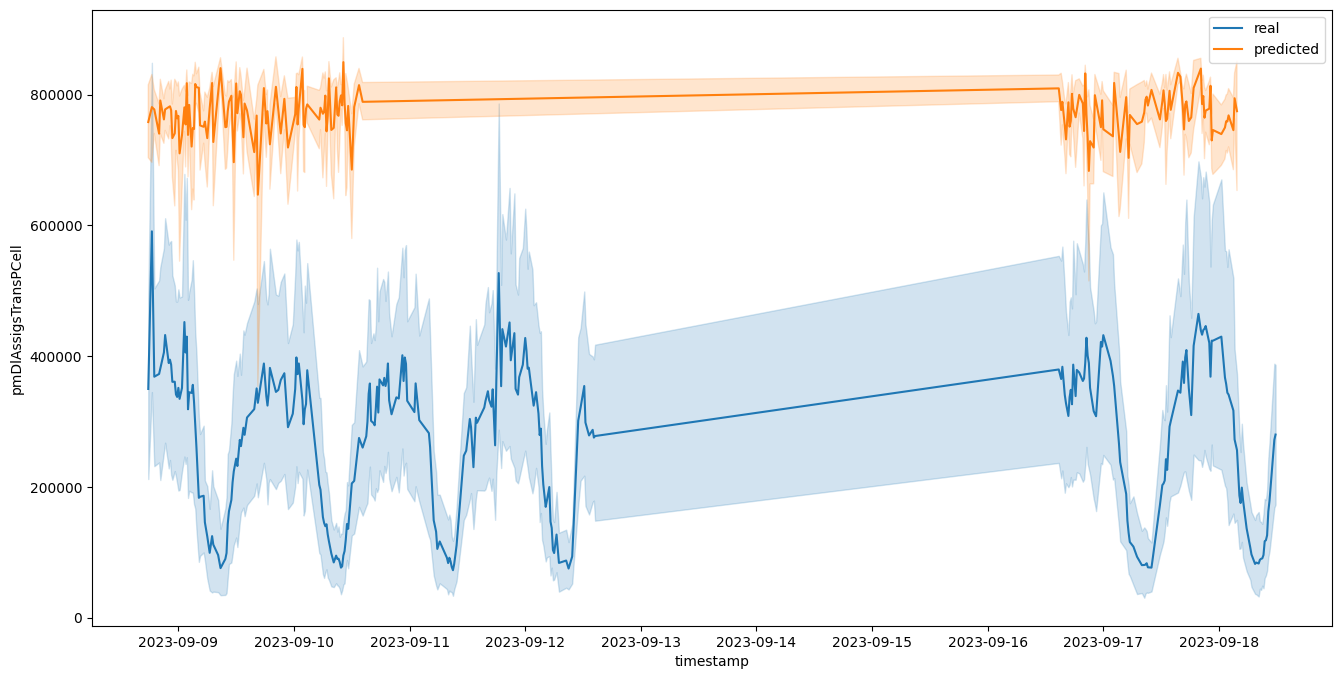

In [17]:
plt.figure(figsize=(16,8))
sns.lineplot(df_temporary.timestamp, df_temporary.pmDlAssigsTransPCell[:4500], label="real")
#sns.lineplot(filter_new_predicted_df.timestamp, filter_new_predicted_df.pmDlAssigsTransPCell, label="predicted")
sns.lineplot(df_temporary.timestamp, filter_new_predicted_df.pmDlAssigsTransPCell, label="predicted")
plt.legend()
plt.show()

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


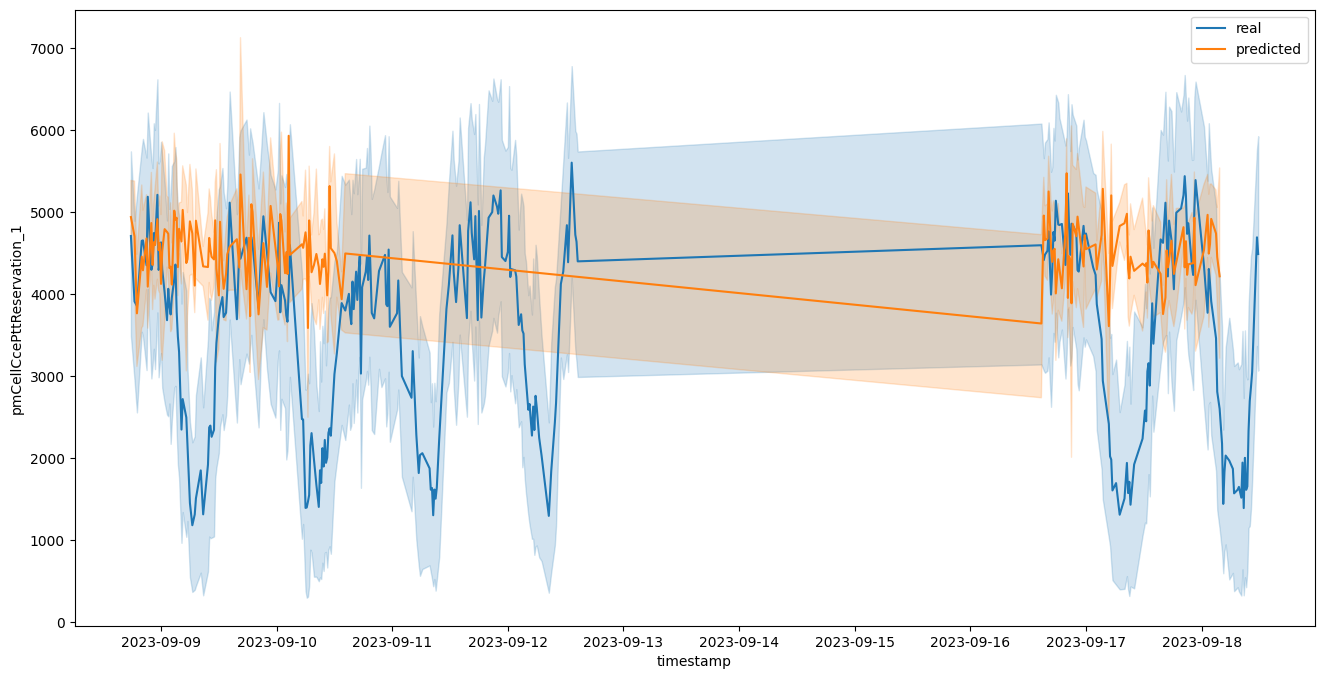

In [18]:
plt.figure(figsize=(16,8))
sns.lineplot(df_temporary.timestamp, df_temporary.pmCellCcePttReservation_1[:4500], label="real")
#sns.lineplot(filter_new_predicted_df.timestamp, filter_new_predicted_df.pmDlAssigsTransPCell, label="predicted")
sns.lineplot(df_temporary.timestamp, filter_new_predicted_df.pmCellCcePttReservation_1, label="predicted")
plt.legend()
plt.show()

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


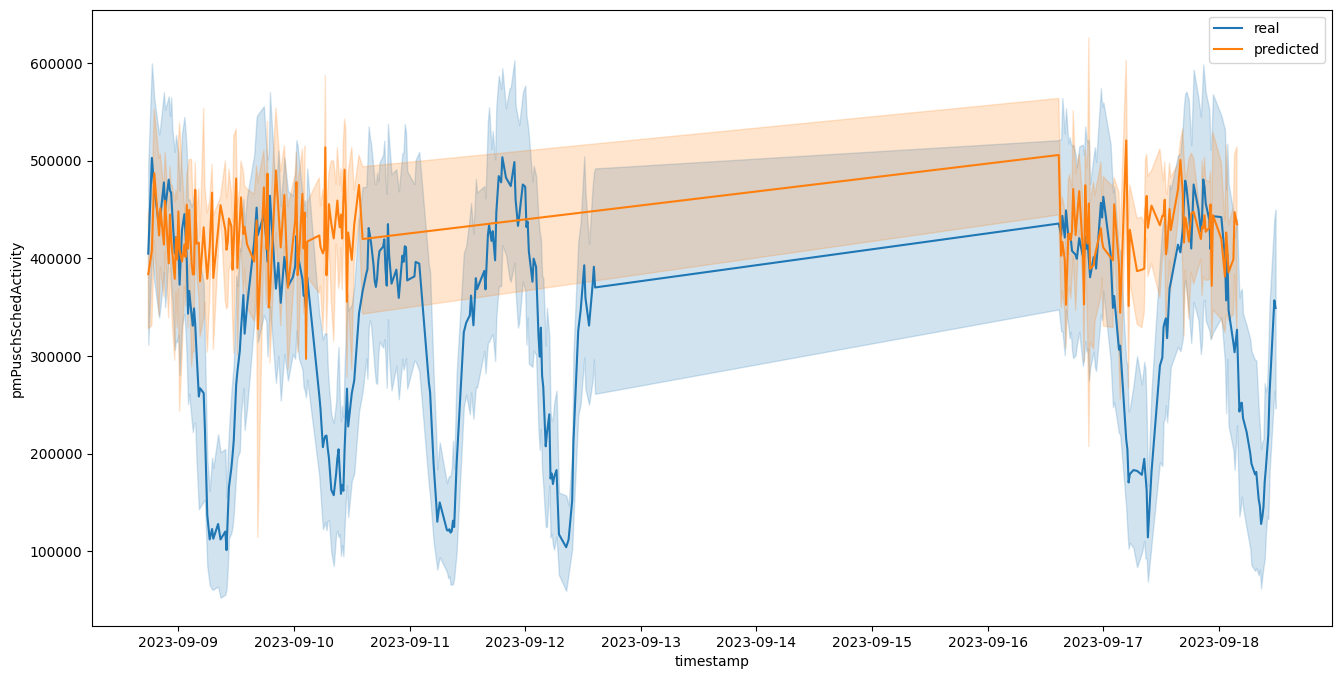

In [19]:
plt.figure(figsize=(16,8))
sns.lineplot(df_temporary.timestamp, df_temporary.pmPuschSchedActivity[:4500], label="real")
#sns.lineplot(filter_new_predicted_df.timestamp, filter_new_predicted_df.pmDlAssigsTransPCell, label="predicted")
sns.lineplot(df_temporary.timestamp, filter_new_predicted_df.pmPuschSchedActivity, label="predicted")
plt.legend()
plt.show()

In [20]:
# R2 SCORE

In [55]:
# target_real = df_temporary.drop("timestamp", axis=1)
# target_pred = filter_new_predicted_df.drop(["timestamp", "hour", "day_of_week", "day_of_month", "month"], axis=1)

In [68]:
#target_real.shape, target_pred.shape 

In [67]:
# common_ts = pd.merge(df_temporary[["timestamp"]], filter_new_predicted_df[["timestamp"]], on="timestamp", how="inner")
# common_ts

In [66]:
# df_temporary["counter_a"] = df_temporary.groupby('timestamp').cumcount()
# filter_new_predicted_df["counter_b"] = filter_new_predicted_df.groupby('timestamp').cumcount()

In [25]:
# from sklearn.metrics import r2_score

In [64]:
#r2_scores_ = r2_score(target_real, target_pred, multioutput='raw_values')

In [65]:
# for i, score in enumerate(r2_scores_):
#     #fit = check_r2_score(score)
#     print(f"R2 score for Target {i+1}: {score}")